# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,  GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# Load in the data
azdias = pd.read_csv('../data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../data/Udacity_CUSTOMERS_052018.csv', sep=';')

C:\Users\mari_\AppData\Local\Temp\ipykernel_19520\3577918986.py:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  azdias = pd.read_csv('../data/Udacity_AZDIAS_052018.csv', sep=';')
C:\Users\mari_\AppData\Local\Temp\ipykernel_19520\3577918986.py:3: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  customers = pd.read_csv('../data/Udacity_CUSTOMERS_052018.csv', sep=';')


In [3]:
# First look at azdias
azdias.head(10)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
5,910244,3,1.0,10.0,NaN,NaN,NaN,NaN,10.0,5.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1
6,910248,-1,9.0,0.0,NaN,NaN,NaN,NaN,NaN,4.0,...,2.0,7.0,10.0,10.0,3.0,9.0,5.0,4,2,2
7,910261,-1,1.0,14.0,NaN,NaN,NaN,NaN,14.0,6.0,...,2.0,10.0,12.0,9.0,5.0,9.0,1.0,1,1,1
8,645145,-1,9.0,16.0,NaN,NaN,NaN,NaN,16.0,2.0,...,4.0,8.0,11.0,8.0,5.0,8.0,1.0,6,1,3
9,645153,-1,5.0,17.0,NaN,NaN,NaN,NaN,17.0,9.0,...,4.0,1.0,1.0,1.0,4.0,3.0,7.0,4,2,3


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [4]:
def clean_dataframe(df, col_thr=0.3, row_thr=0.3):
    '''
    Clean dataframe by removing duplicates and imputing missing values.
    Arguments:
        - df: pd.DataFrame - dataframe to be cleaned
        - col_thr: float - NaN threshold for droping columns
        - row_thr: float - NaN threshold for droping rows
    Returns:
        - df: pd.DataFrame - cleaned dataframe
        - na_col_ratio: pd.Series - ratio of NaNs per column
        - na_row_ratio: pd.Series - ratio of NaNs per row
        - drop_col: list - label of dropped columns
        - drop_row: list - index of dropped rows
    '''    
    
    # Check if there are NaN rows and/or columns (if any)
    df = df.dropna(axis=0, how='all', inplace=False)
    df = df.dropna(axis=1, how='all', inplace=False)

    # Look for duplicated rows (if any)
    df = df.drop_duplicates(keep='first', inplace=False)

    # Check ratio of NaN values per column
    na_col_ratio = df.isna().mean(axis=0)
    na_row_ratio = df.isna().mean(axis=1)

    # Drop columns with 'na_ratio' higher than thresold (if any)
    drop_col = df.columns[na_col_ratio>col_thr].values
    df = df.drop(columns=drop_col, inplace=False)
    
    # Drop rows with 'na_ratio' higher than thresold (if any)
    drop_row = df.index[na_row_ratio>row_thr].values
    df = df.drop(axis = 0, index=drop_row, inplace=False)

    # Convert categoricals to numericals 
    cat_col = df.select_dtypes(['object']).columns
    df[cat_col] = df[cat_col].apply(lambda x: x.astype('category').cat.codes, axis=0)

    # Replace outliers by median
    # Columns: 'GEB URTSJAHR','KBA13_ANZAHL_PKSW','MIN_GEBAEUDEJAHR',
    # 'ANZ_HAUSALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_PERSONEN','ANZ_TITEL'

    return df, na_col_ratio, na_row_ratio, drop_col, drop_row

def keep_common_columns(df_list):
    '''
    Drop columns that are not common between the dataframes.
    Arguments:
        - df_list: list of pd.DataFrame - dataframes with different column labels
    Returns:
        - df_list_new: list of pd.DataFrame - dataframes with equal column labels
    ''' 
    # Initialize parameters
    columns_to_keep = list()
    df_list_new = list()

    # Look for columns that are common between the dataframes
    for i, df in enumerate(df_list):
        if i > 0:
            columns_to_keep = np.intersect1d(columns_to_keep, 
                                     df.columns)
        else:
            columns_to_keep = df.columns  

    # Drop columns that are not common    
    for df in df_list:
        df = df.drop(columns=np.setdiff1d(df.columns,
                                        columns_to_keep))
        df_list_new.append(df)
    
    return df_list_new

During data preprocessing, the number of missing values per column and row is first analysed. To avoid generalization errors and overfitting due to imputation, all the columns and rows whose NaN ratio is greater than 0.3 are be dropped. In all cases, less than 30% of the missing values are discarded (as can be seen in the following graphs). In addition, duplicate rows are dropped, and the categoricals columns are converted into integers. The demographics information dropped during preprossesing could not be mapped using the provided files (their description was missing), however by common sense they must be related to childrens' age.

In [5]:
# Clean azdias
azdias_clean, na_col, na_row, drop_col, drop_row = clean_dataframe(azdias)

# Dropped columns
print('{} columns were dropped, namely {}.'.format(len(drop_col), drop_col))

# Dropped rows
print('{} rows were dropped.'.format(len(drop_row)))

azdias_clean.head(10)

6 columns were dropped, namely ['ALTER_KIND1' 'ALTER_KIND2' 'ALTER_KIND3' 'ALTER_KIND4' 'EXTSEL992'
 'KK_KUNDENTYP'].
105805 rows were dropped.


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,910220,-1,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
5,910244,3,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1
6,910248,-1,9.0,0.0,NaN,4.0,0.0,0.0,1.0,3.0,...,2.0,7.0,10.0,10.0,3.0,9.0,5.0,4,2,2
7,910261,-1,1.0,14.0,14.0,6.0,0.0,0.0,1.0,5.0,...,2.0,10.0,12.0,9.0,5.0,9.0,1.0,1,1,1
8,645145,-1,9.0,16.0,16.0,2.0,1.0,0.0,1.0,2.0,...,4.0,8.0,11.0,8.0,5.0,8.0,1.0,6,1,3
9,645153,-1,5.0,17.0,17.0,9.0,0.0,0.0,1.0,7.0,...,4.0,1.0,1.0,1.0,4.0,3.0,7.0,4,2,3
10,645165,0,1.0,10.0,10.0,6.0,0.0,0.0,1.0,6.0,...,4.0,8.0,11.0,10.0,6.0,9.0,5.0,3,2,3


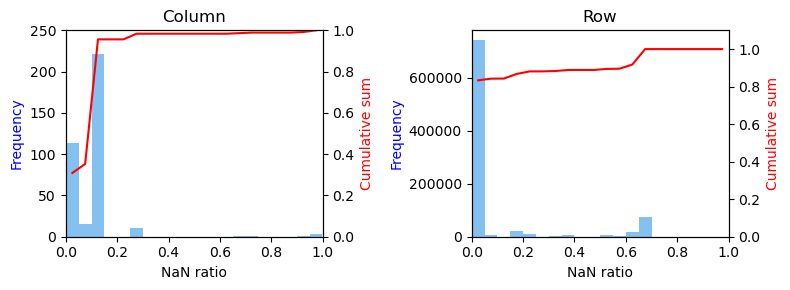

In [6]:
def plot_na_values(na_col, na_row):
    '''
    Plot the histograms of the NaN ratios per columns and rows
    Arguments:
        - na_col: pd.Series - ratio of NaNs per column
        - na_row: pd.Series - ratio of NaNs per row
    ''' 
    # Columns
    fig, ax = plt.subplots(1,2,figsize=(8, 3))
    counts, bins = np.histogram(na_col, bins=20)
    ax[0].hist(bins[:-1], bins, color=[.2,.6,.9], weights=counts, alpha = 0.6)
    ax[0].set_xlabel('NaN ratio')
    ax[0].set_ylabel('Frequency',color='b')
    ax[0].set_title('Column')
    ax[0].set_xlim(0,1)
    ax[0].set_ylim(0,250)

    ax2 = ax[0].twinx()
    ax2.plot((bins[:-1] + bins[1:])/2, np.cumsum(counts)/sum(counts),color='r')
    ax2.set_ylabel('Cumulative sum',color='r')
    ax2.set_xlim(0,1)
    ax2.set_ylim(0,1)

    # Rows    
    counts, bins = np.histogram(na_row, range=[0,1], bins=20)
    ax[1].hist(bins[:-1], bins, color=[.2,.6,.9], weights=counts, alpha = 0.6)
    ax[1].set_xlabel('NaN ratio')
    ax[1].set_ylabel('Frequency',color='b')
    ax[1].set_title('Row')
    ax[1].set_xlim(0,1)

    ax2 = ax[1].twinx()
    ax2.plot((bins[:-1] + bins[1:])/2, np.cumsum(counts)/sum(counts),color='r')
    ax2.set_ylabel('Cumulative sum',color='r')
    ax2.set_xlim(0,1)
    ax2.set_ylim(0,1.1)
    ax2

    fig.tight_layout()
    plt.show()
    return

# Visualization: plot missing values of azdias
plot_na_values(na_col, na_row)

In [7]:
# First look at customers
customers.head(10)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3
5,143888,1,1.0,11.0,NaN,NaN,NaN,NaN,10.0,1.0,...,1.0,6.0,9.0,1.0,2,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,3
6,143904,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,1,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
7,143910,1,1.0,10.0,NaN,NaN,NaN,NaN,9.0,1.0,...,1.0,6.0,9.0,3.0,3,FOOD,SINGLE_BUYER,0,1,4
8,102160,2,3.0,5.0,NaN,NaN,NaN,NaN,4.0,74.0,...,9.0,6.0,3.0,4.0,3,COSMETIC,MULTI_BUYER,0,2,4
9,102173,1,1.0,20.0,NaN,NaN,NaN,NaN,13.0,1.0,...,4.0,2.0,9.0,5.0,1,COSMETIC,MULTI_BUYER,0,1,3


In [8]:
# Clean costumers
customers_clean, na_col, na_row, drop_col, drop_row = clean_dataframe(customers,col_thr=0.7,row_thr=0.7)
customers_clean.head(10)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,10.0,1.0,0.0,0.0,2.0,1.0,...,2.0,6.0,9.0,7.0,3,1,0,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,0.0,3.0,NaN,...,3.0,0.0,9.0,NaN,3,2,1,0,1,4
2,143872,-1,1.0,6.0,0.0,1.0,0.0,0.0,1.0,1.0,...,11.0,6.0,9.0,2.0,3,1,0,0,2,4
3,143873,1,1.0,8.0,8.0,0.0,NaN,0.0,0.0,1.0,...,2.0,NaN,9.0,7.0,1,0,0,0,1,4
4,143874,-1,1.0,20.0,14.0,7.0,0.0,0.0,4.0,7.0,...,4.0,2.0,9.0,3.0,1,2,0,0,1,3
5,143888,1,1.0,11.0,10.0,1.0,0.0,0.0,2.0,1.0,...,1.0,6.0,9.0,1.0,2,1,0,0,1,3
6,143904,2,1.0,10.0,10.0,1.0,0.0,0.0,2.0,1.0,...,2.0,6.0,9.0,7.0,1,1,0,0,1,4
7,143910,1,1.0,10.0,9.0,1.0,0.0,0.0,2.0,1.0,...,1.0,6.0,9.0,3.0,3,2,1,0,1,4
8,102160,2,3.0,5.0,4.0,74.0,2.0,0.0,1.0,82.0,...,9.0,6.0,3.0,4.0,3,0,0,0,2,4
9,102173,1,1.0,20.0,13.0,1.0,0.0,0.0,3.0,1.0,...,4.0,2.0,9.0,5.0,1,0,0,0,1,3


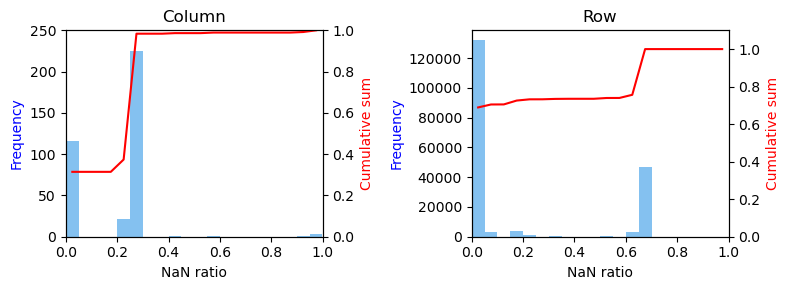

In [9]:
# Visualization: plot missing values of costumers
plot_na_values(na_col, na_row)

In [10]:
# Drop columns that are not common between the dataframes
[azdias_clean, customers_clean] = keep_common_columns([azdias_clean, customers_clean])

# Final azdias shape
print('Shape azdias: {}'.format(azdias_clean.shape))

# Final costumers shape
print('Shape customers: {}'.format(customers_clean.shape))

Shape azdias: (785416, 360)
Shape customers: (191649, 360)


To identify the most representative features in 'customers', the Principal Component Analysis (PCA) is utilized. To this end, a sklearn Pipeline was created to impute missing values with the median, normalize features, and apply the PCA.

In [11]:
def build_pca_model(n_pca):
    '''Build the PCA pipeline
    Arguments:
        n_pca: int - pca components
    Returns:
        pipeline: sklearn.pipeline.Pipeline - signal processing pipeline
    '''
    pipeline = Pipeline([
            ('impute', SimpleImputer(missing_values=np.nan, strategy='median')),
            ('scale', StandardScaler()),
            ('pca', PCA(n_pca)),
    ])
    return pipeline

n_comp = 170    # number of PCs

# Build the PCA model
model = build_pca_model(n_pca=n_comp)

# Fit model for customers
pca_data_cus = model.fit_transform(customers_clean.to_numpy())

Text(0, 0.5, 'Cumulative sum')

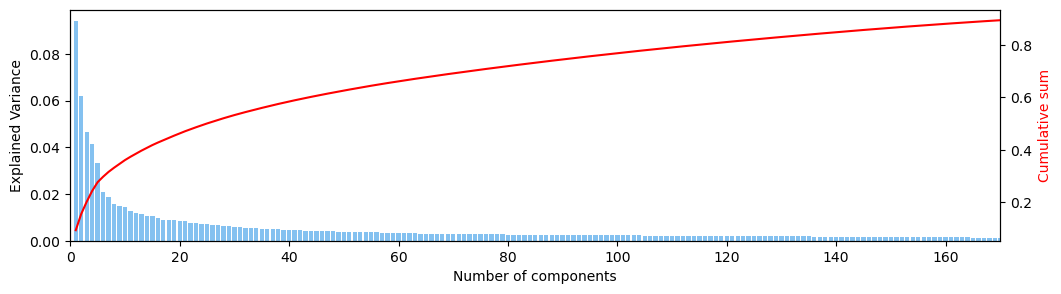

In [12]:
# Get the explained variance ratio
var = model['pca'].explained_variance_ratio_

# Create dataframe containing the PCs
pc_names = ['PC'+str(i+1) for i in range(model['pca'].n_components_)]
pca_df = pd.DataFrame(np.transpose(model['pca'].components_),columns=pc_names,index=azdias_clean.columns)

# Visualization: 
# Explained variance vs PCA components
fig, ax = plt.subplots(1,figsize=(12, 3))
ax.bar(range(1, model['pca'].n_components_+1)[:n_comp], var[:n_comp],color=[.2,.6,.9],alpha=0.6)
ax.set_xlabel('Number of components')
ax.set_ylabel('Explained Variance')
ax.set_xlim(0,n_comp)

ax2 = ax.twinx()
ax2.plot(range(1, model['pca'].n_components_+1)[:n_comp], np.cumsum(var[:n_comp]),color='r')
ax2.set_ylabel('Cumulative sum',color='r')


It is noteworthy to mention that the cumulative variance reaches 90% at 170 components.

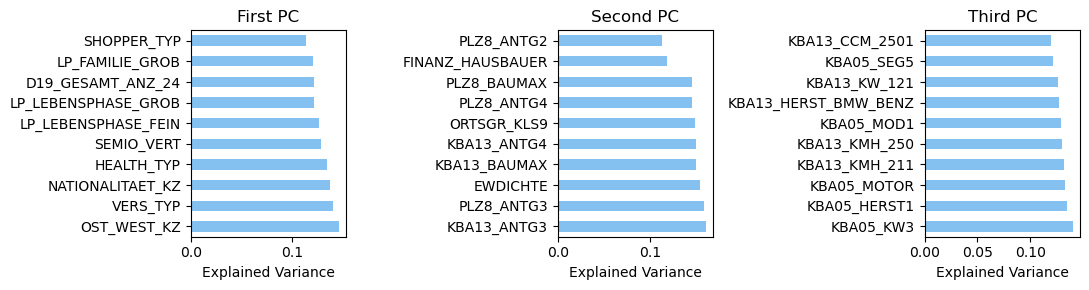

In [13]:
# Visualization 
# Highest PCA contributions
fig, ax = plt.subplots(1,3,figsize=(11, 3))
max_comp = 10   # number of features

# PCA 1
pca_df["PC1"].sort_values(ascending=False).iloc[:max_comp].plot.barh(ax=ax[0]
            ,color=[.2,.6,.9],alpha=0.6)
ax[0].set_xlabel('Explained Variance')
ytl = ax[0].get_yticklabels()
ax[0].set_yticklabels(ytl, fontsize=10)
ax[0].set_title('First PC')

# PCA 2
pca_df["PC2"].sort_values(ascending=False).iloc[:max_comp].plot.barh(ax=ax[1]
            ,color=[.2,.6,.9],alpha=0.6)
ax[1].set_xlabel('Explained Variance')
ytl = ax[1].get_yticklabels()
ax[1].set_yticklabels(ytl, fontsize=10)
ax[1].set_title('Second PC')

# PCA 3
pca_df["PC3"].sort_values(ascending=False).iloc[:max_comp].plot.barh(ax=ax[2]
            ,color=[.2,.6,.9],alpha=0.6)
ax[2].set_xlabel('Explained Variance')
ytl = ax[2].get_yticklabels()
ax[2].set_yticklabels(ytl, fontsize=10)
ax[2].set_title('Third PC')

fig.tight_layout()
plt.show()

The first principal component is related to personal information, such as insurance, nationality, health, lifestage, family, and mail-orders in the last 2 years. By contrast, the second component is mainly affected by the sub-postcode PLZ8, containing information on the number of family houses in the region, number/density of inhabitants, etc. Last but not least, the third component can be associated with the microcell, being mostly affected by the share of cars with high engine power/maximum speed (in the microcell and PLZ8), engine size, and share of Mercedes and BWM.

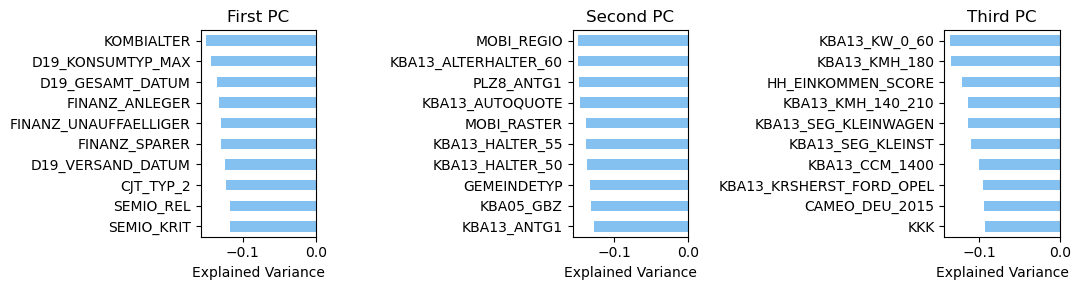

In [14]:
# Visualization 
# Lowest PCA contributions
fig, ax = plt.subplots(1,3,figsize=(11, 3))

# PCA 1
pca_df["PC1"].sort_values(ascending=False).iloc[-max_comp:].plot.barh(ax=ax[0]
            ,color=[.2,.6,.9],alpha=0.6)
ax[0].set_xlabel('Explained Variance')
ytl = ax[0].get_yticklabels()
ax[0].set_yticklabels(ytl, fontsize=10)
ax[0].set_title('First PC')

# PCA 2
pca_df["PC2"].sort_values(ascending=False).iloc[-max_comp:].plot.barh(ax=ax[1]
            ,color=[.2,.6,.9],alpha=0.6)
ax[1].set_xlabel('Explained Variance')
ytl = ax[1].get_yticklabels()
ax[1].set_yticklabels(ytl, fontsize=10)
ax[1].set_title('Second PC')

# PCA 3
pca_df["PC3"].sort_values(ascending=False).iloc[-max_comp:].plot.barh(ax=ax[2]
            ,color=[.2,.6,.9],alpha=0.6)
ax[2].set_xlabel('Explained Variance')
ytl = ax[2].get_yticklabels()
ax[2].set_yticklabels(ytl, fontsize=10)
ax[2].set_title('Third PC')

fig.tight_layout()
plt.show()

Regargind the features that contributed the least, the first component is related to aspects such as religion, financial topology (invester/money saver/unremarkable) and customer-journey topology; the second to moving patterns and share of car owners between 46 and 60 years old; and the third to the purchasing power, share of cars with less than 61 KW engine power and specific microcell groups.

In [15]:
# Fit model for customers
pca_data_pop = model.fit_transform(azdias_clean.to_numpy())

# Create dataframes with data projected onto the PCs
pca_df_cus = pd.DataFrame(pca_data_cus,columns=pc_names)    # costumers
pca_df_pop = pd.DataFrame(pca_data_pop,columns=pc_names)    # population


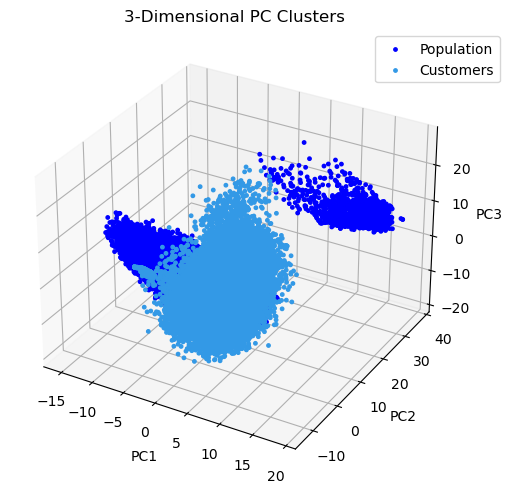

In [16]:
# Visualization 
# Projection of data onto 3-D space
n_points = 80000    # number of points

fig = plt.figure(figsize=(5, 5), constrained_layout=True)
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3-Dimensional PC Clusters')
colors = ['b', 'r']

ax.scatter(pca_df_pop.iloc[:n_points,0].values, pca_df_pop.iloc[:n_points,1].values, 
           pca_df_pop.iloc[:n_points,2].values, color='b', s=6, 
           label='Population', alpha = 1)

ax.scatter(pca_df_cus.iloc[:n_points,0].values, pca_df_cus.iloc[:n_points,1].values, 
           pca_df_cus.iloc[:n_points,2].values, color=[.2,.6,.9], s=6, 
           label='Customers', alpha = 1)

ax.legend(bbox_to_anchor=(0.8, 1), loc='upper left', frameon=True)
plt.show()

The dataframes 'population' and 'customers' are projected onto a 3-D space whose canical basis are the first, second and third principal components. Notably, three cluters can be identified (2 from population and 1 from customers). A simple way to distinguish the individuals from population that are more likely to become customers is to select all individuals within the range of the customer cluster.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [17]:
# Load data
mailout_train = pd.read_csv('../data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_test = pd.read_csv('../data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

C:\Users\mari_\AppData\Local\Temp\ipykernel_19520\1497461626.py:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_train = pd.read_csv('../data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
C:\Users\mari_\AppData\Local\Temp\ipykernel_19520\1497461626.py:3: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_test = pd.read_csv('../data/Udacity_MAILOUT_052018_TEST.csv', sep=';')


In [18]:
# MAILOUT TRAIN  shape
print('MAILOUT TRAIN - Shape: {}'.format(mailout_train.shape))

# Clean MAILOUT TRAIN 
mailout_clean, na_ratio_col, na_ratio_row, dropped_col, dropped_row = clean_dataframe(mailout_train, col_thr=0.8, row_thr=0.8)
print('MAILOUT TRAIN CLEANED - Shape: {}'.format(mailout_clean.shape))

# Check the dropped columns
print('Dropped columns: {}'.format(dropped_col))

# Check data balance
print(mailout_clean['RESPONSE'].value_counts()/mailout_clean.shape[0]) 

MAILOUT TRAIN - Shape: (42962, 367)
MAILOUT TRAIN CLEANED - Shape: (42962, 363)
Dropped columns: ['ALTER_KIND1' 'ALTER_KIND2' 'ALTER_KIND3' 'ALTER_KIND4']
0    0.987617
1    0.012383
Name: RESPONSE, dtype: float64


To cross-validade the propose model, the labeled dataframe is slipt into train and test. Before that, data imbalance is first taken into account. At first, 98.77% of the dataframe was labeled as '0' and 1,23% (266 samples) as '1'. Then, the majority class is randomly downsampled to 532 samples using bootstrapping without replacement, and the minority class was upsampled to 532 samples by adding gaussian noise to the provided data. An alternative downsampling technique that could have been used is clustering.

In [19]:
# Create a dataframe for the majority class
majority_class = mailout_clean[mailout_clean['RESPONSE']==0]

# Create a dataframe for the minority class
minority_class = mailout_clean[mailout_clean['RESPONSE']==1]

# Downsample the majority class
mail_downsampled = resample(majority_class,
                replace=False,
                n_samples=minority_class.shape[0]*2,
                random_state=42)

# Take a look at the downsampled dataframe
mail_downsampled.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
13952,55989,-1,1.0,13.0,0.0,5.0,0.0,0.0,3.0,5.0,...,1.0,1.0,1.0,4.0,9.0,2.0,1,0,1,3
20040,12606,2,1.0,8.0,8.0,24.0,0.0,0.0,0.0,25.0,...,10.0,13.0,10.0,NaN,9.0,4.0,3,0,2,4
15659,53422,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,0,2,2
220,25015,-1,1.0,0.0,0.0,5.0,0.0,0.0,2.0,4.0,...,9.0,8.0,5.0,6.0,9.0,4.0,3,0,2,3
6579,41645,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3,0,1,3


In [20]:
def upsample(df, y, y_name='RESPONSE', y_pos=360):
    '''
    Upsample by adding gaussian noise, doubling the current df shape.
    Arguments:
        - df: pd.DataFrame - dataframe to be upsample
        - y: pd.Series - labels
        - y_name: name of labels
        - y_pos: position of labels in dataframe
    Returns:
        - df: pd.DataFrame - cleaned dataframe
    '''        
    # Duplicate labels
    y = np.concatenate((y,y),axis=0)

    # Reshape for concatenation
    y = np.reshape(y,newshape=(y.shape[0],1))

    # Add gaussian noise
    np.random.seed(42)
    noise = df.to_numpy()+np.random.normal(0, 1, size=df.shape)
    
    # Concatenate to dataframe
    df_upsampled = np.concatenate((noise,df.to_numpy()),axis=0)
    
    # Create new dataframe
    df_upsampled = pd.DataFrame(data=df_upsampled, columns=minority_class.columns) 
    
    # Insert the labels
    df_upsampled.insert(y_pos, y_name, y)

    return df_upsampled


# Get the labels from the minority_class
y = minority_class['RESPONSE']

# Drop the response column for data resampling
minority_class = minority_class.drop(columns=['RESPONSE'])

# Upsample
mail_upsampled = upsample(minority_class, y)
mail_upsampled.head()


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,21511.496714,2.861736,1.647689,15.523030,9.765847,0.765863,1.579213,0.767435,1.530526,1.542560,...,0.840061,0.980984,-0.002529,3.981487,8.711341,1.322719,1.172769,1,2.519347,4.532739
1,61904.891240,2.401712,1.690144,9.598780,10.224092,8.012592,0.097676,-0.773010,1.024510,7.497998,...,9.103302,6.114228,3.150302,5.636388,8.943054,2.307802,4.289832,1,-0.348185,3.743264
2,15467.170865,0.816017,1.018434,13.347582,12.460240,0.221695,0.195845,-0.978373,4.408253,-0.702584,...,0.571885,2.500760,1.850222,4.651348,8.650742,2.678365,3.076748,1,1.381935,4.430042
3,25212.030283,1.238789,0.740958,8.803650,7.928399,4.962778,0.727630,0.051946,2.732640,2.919283,...,1.734878,2.662881,2.173474,6.181022,7.703168,3.399688,2.348643,1,0.471383,4.586364
4,83462.238283,1.021272,1.308833,12.702215,10.240753,3.601683,0.565510,-1.760763,2.753342,1.381158,...,0.939339,1.291593,-0.513714,4.196860,7.415864,3.267127,1.508725,1,-0.581191,4.895038


In [21]:
# Concatenate dataframes
mail_resampled = pd.concat([mail_downsampled,mail_upsampled])

# Check the number of responses
print(mail_resampled['RESPONSE'].value_counts()/mail_resampled.shape[0])

0    0.5
1    0.5
Name: RESPONSE, dtype: float64


In [22]:
# Prepare for train/test split
y = mail_resampled['RESPONSE']
X = mail_resampled.drop(columns=['RESPONSE'], inplace=False)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Now four different supervised machine leaning classifiers are tested and evaluated, including the KNN, Random Forest, Decision Tree and AdaBoost classifiers.

In [23]:
def build_ml_model(classifier, parameters):
    """
    Build the machine learning pipeline
    Arguments:
        - classifier - sklearn classifier object
        - parameters - dict - parameters for optimization
    Returns:
        - model - GridSearchCV pipeline - machine learning model
    """
    pipeline = Pipeline([
    ('impute', SimpleImputer(missing_values=np.nan, strategy='median')),
    #('scale', StandardScaler()),
    ('clf', classifier),
    ]) 
    
    model = GridSearchCV(pipeline, param_grid=parameters)
    return model

def evaluate_model(model, X_test, Y_test):
    """
    Predict and evaluate the machine learning model
    Arguments:
        - model - GridSearchCV pipeline 
        - X_test - pd.Series - test data
        - Y_test - pd.DataFrame - target
    """
    Y_pred = model.predict(X_test)
    print('---------------------------')
    y_target = Y_test
    y_pred = Y_pred
    print(classification_report(y_target, y_pred))


In [36]:
# Evaluated classifiers
classifiers = [
    KNeighborsClassifier(),
    RandomForestClassifier(random_state=42),
    DecisionTreeClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
    ]

# Optimization parameters
parameter =[    
                # KNN
                { 
                'clf__n_neighbors': [3, 5, 7],
                'clf__p': [1, 2],
                },
                # Random Forest
                { 
                'clf__n_estimators': [10, 50, 100, 150, 200],
                'clf__min_samples_split': [3, 6],
                'clf__max_features': [X_test.shape[1],'sqrt'],
                'clf__min_samples_leaf': [1, 3, 5],
                },
                # Decision Tree
                { 
                'clf__min_samples_split': [3, 6],
                'clf__max_features': [X_test.shape[1],'sqrt'],
                'clf__min_samples_leaf': [1, 3, 5],
                },
                # AdaBoost
                { 
                'clf__n_estimators': [10, 50, 100, 150, 200, 400],
                },
            ]   

models = list()
for i, classifier in enumerate(classifiers):
    # Build model
    model = build_ml_model(classifier, parameter[i])

    # Fit in the training data
    model.fit(X_train, y_train)   
    models.append(model)
    
    # Evaluate model
    print(classifier)
    print("Best Parameters: \n{}\n".format(model.best_params_))
    evaluate_model(model, X_test, y_test)

KNeighborsClassifier()
Best Parameters: 
{'clf__n_neighbors': 5, 'clf__p': 2}

---------------------------
              precision    recall  f1-score   support

           0       0.59      0.52      0.55       362
           1       0.55      0.62      0.58       341

    accuracy                           0.57       703
   macro avg       0.57      0.57      0.57       703
weighted avg       0.57      0.57      0.57       703

RandomForestClassifier(random_state=42)
Best Parameters: 
{'clf__max_features': 362, 'clf__min_samples_leaf': 3, 'clf__min_samples_split': 3, 'clf__n_estimators': 50}

---------------------------
              precision    recall  f1-score   support

           0       0.79      0.77      0.78       362
           1       0.77      0.79      0.78       341

    accuracy                           0.78       703
   macro avg       0.78      0.78      0.78       703
weighted avg       0.78      0.78      0.78       703

DecisionTreeClassifier(random_state=42)
Bes

Notably, the AdaBoost and Random Forest Classifiers presented better evaluation metrics in comparison with k-NN and Decision Tree. As Random Forest presented the highest recall (79% for label '1'), it was choseen as the best Classifier. It is pertinent to point out that best results could be achieved by utilizing a neural network as classifier.

In [37]:
# Shape of MAILOUT TEST
print('MAILOUT TEST - Shape: {}'.format(mailout_test.shape))

# Clean MAILOUT TEST
mailout_clean_test, na_ratio_col, na_ratio_row, dropped_col, dropped_row = clean_dataframe(mailout_test, col_thr=0.8, row_thr=0.8)
print('MAILOUT TEST CLEANED - Shape: {}'.format(mailout_clean_test.shape))

# Check the dropped columns
print('Dropped columns: {}'.format(dropped_col))

mailout_clean_test.head()

MAILOUT TEST - Shape: (42833, 366)
MAILOUT TEST CLEANED - Shape: (42833, 362)
Dropped columns: ['ALTER_KIND1' 'ALTER_KIND2' 'ALTER_KIND3' 'ALTER_KIND4']


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,6.0,2.0,0.0,0.0,2.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,0.0,20.0,0.0,0.0,1.0,21.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,11.0,2.0,0.0,0.0,4.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,13.0,1.0,0.0,0.0,4.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


Finally, the Random Forest Classifier is applied to 'MAILOUT TEST', and the target is predicted. In the end, 10304 persons were targeted for the marketing campaign.

0    32529
1    10304
Name: PREDICTED RESPONSE, dtype: int64


Text(0, 0.5, 'Frequency')

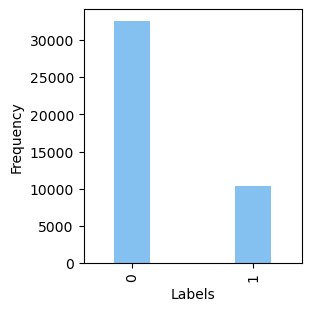

In [39]:
# Drop different columns between dataframes (if any)
keep_common_columns([mailout_clean_test,mailout_clean])

# Predict
idx = 1 # select the Random Forest index
Y = models[idx].predict(mailout_clean_test) # predict

# Create dataframe
mailout_clean_test.insert(360, 'PREDICTED RESPONSE', Y)
print(mailout_clean_test['PREDICTED RESPONSE'].value_counts())

# Visualization
# Plot label distribution
fig = plt.figure(figsize=(3, 3), constrained_layout=True)
ax = fig.add_subplot()
mailout_clean_test['PREDICTED RESPONSE'].value_counts().plot.bar(ax=ax,
                                    color=[.2,.6,.9],alpha=0.6, width=0.3)
ax.set_xlabel('Labels')
ax.set_ylabel('Frequency')
